**Gordon Doore, Ghailan Fadah**

Spring 2024

CS 443: Bio-inspired Machine Learning

# Project 5: Recurrent Neural Networks

In this project, you will build a **recurrent neural network** in TensorFlow and train it on a text corpus representing children's fairy tales and, once trained, the network will generate a novel story following a text prompt that you provide. The neural network will process text data as a **character-level model**.

### Reminder: AI Policy

To improve the quality of your learning and out of fairness to your hardworking classmates, AI (e.g. ChatGPT, Copilot, etc.) should NOT be used in ANY way on this project and extensions. This includes both written analysis, plotting, and code. I will only grade your work, not an AI's. I will stop grading your project if I notice AI-generated content (in any capacity).

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.show()
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 1: Three Little Pigs Dev corpus

In order to make this a one week project, you are being the provided with the preprocessed datasets. The original story text files are provided, but for the main project you should use the preprocessed versions (`.npz` and `pkl` files).

*Building your own preprocessing pipeline from the fairytale raw .txt file would be a good extension!*

### 1a. Load in the dev corpus

Run the cell below to load in *The Three Little Pigs* story that will serve as our dev corpus (`pigs_dev_7`).

In [2]:
#mount drive:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/data"


Mounted at /content/drive


In [3]:
pigs_dev = np.load(data_path+'/pigs_dev_7.npz')
x_pigs = pigs_dev['x']
y_pigs = pigs_dev['y']

print(f'Three Little Pigs dev set shape: {x_pigs.shape}')
print(f'Three Little Pigs dev labels shape: {y_pigs.shape}')

with open(data_path+'/pigs_dev_char2ind_map.pkl', 'rb') as file:
    char2ind_map_pigs = pickle.load(file)
    print('Three Little Pigs char2ind map loaded.')

with open(data_path+'/pigs_dev_ind2char_map.pkl', 'rb') as file:
    ind2char_map_pigs = pickle.load(file)
    print('Three Little Pigs ind2char map loaded.')

Three Little Pigs dev set shape: (345, 2, 7)
Three Little Pigs dev labels shape: (345, 2, 7)
Three Little Pigs char2ind map loaded.
Three Little Pigs ind2char map loaded.


In [4]:
#question 1
pigs_dev_vocab = ''.join(char2ind_map_pigs.keys())
print(pigs_dev_vocab)
print("vocab length is ",len(pigs_dev_vocab))


 !"',-.:;?ABDEFGHILMNOPRSTVWY_abcdefghijklmnoprstuvwxyz
vocab length is  56


In [5]:
#question 2
print(x_pigs[0].shape)
#question 3
print(y_pigs[0],x_pigs[0])

(2, 7)
[[17 14  1 25 26 22 24]
 [ 1 32 35 35 44  1 31]] [[26 17 14  1 25 26 22]
 [35  1 32 35 35 44  1]]


In [6]:
#question 4
vals = np.array([38, 35, 1, 38, 50, 36, 36, 35, 34, 1, 31, 44, 34, 1, 38, 35, 1, 46, 50, 36, 36, 35, 34]).astype(int)
newString = (pigs_dev_vocab[val] for val in vals)
print(''.join(newString))

he huffed and he puffed


### 1b. Questions

**Question 1:** Use the files loaded above to print out the char vocabulary as one string (call it `pigs_dev_vocab`). How many tokens are in the vocabulary?

There are 56 tokens in the vocab.

**Question 2:**

(a) How many sequences are processed in one mini-batch in the dev corpus? 2 sequences

(b) What is the sequence length? 7 tokens

(c) How many mini-batches are there? 345

**Question 3:** What is the relationship between x and y within each mini-batch? y should be the next step of x, so that y[i] is x[i] shifted over by 1 token

**Question 4:** Use the files loaded above to determine what string the following sequence corresponds to:

`[38, 35, 1, 38, 50, 36, 36, 35, 34, 1, 31, 44, 34, 1, 38, 35, 1, 46, 50, 36, 36, 35, 34]`

he huffed and he puffed

## Task 2: Implement the layers of the RNN

The RNN that you are building consists of 3 layers + the input layer:
1. Input Layer: One-hot codes the current mini-batch of sequences.
2. Embedding Layer: Essentially a Dense layer, the first layer of the network takes input chars that have `M = vocab_sz` features and embeds them into an `H_e` dimensional space, where `H_e` is the number of neurons in the layer. For example, if the vocabulary is 74 chars and there are 5 neurons in the embedding layer, the chars will be embedded into a 5-dimensional space.
3. GRU Layer: This is the recurrent layer that processes data sequentially char-by-char across time steps until the sequence length is reached.
4. Dense Layer: A Dense layer configured with softmax activation that is the same as usual, except for with some extra handling for the 3D input that comes in from the GRU layer below `(N, T, H_GRU)`, where `H_GRU` is the number of neurons in the GRU layer.

### 2a. Implement `one_hot` and `InputLayer`

The `one_hot` function is at the top of in `gru_net.py`.

In [7]:
from gru_net import one_hot, InputLayer

#### Test `one_hot`

In [8]:
dev_xh = one_hot(x_pigs[0], len(pigs_dev_vocab))
dev_yh = one_hot(y_pigs[0], len(pigs_dev_vocab))

print(f'Three Little Pigs dev x first mini-batch one-hot coded shape={dev_xh.shape}')
print(f'Three Little Pigs dev x first mini-batch one-hot coded shape={dev_yh.shape}')
print('Both shapes should be (2, 7, 56)')

print(f'The total number of ones in xh is {tf.reduce_sum(dev_xh)} and should be 14.0')
print(f'The total number of ones in yh is {tf.reduce_sum(dev_yh)} and should be 14.0')

Three Little Pigs dev x first mini-batch one-hot coded shape=(2, 7, 56)
Three Little Pigs dev x first mini-batch one-hot coded shape=(2, 7, 56)
Both shapes should be (2, 7, 56)
The total number of ones in xh is 14.0 and should be 14.0
The total number of ones in yh is 14.0 and should be 14.0


#### Test `InputLayer`

In [9]:
test_input_layer = InputLayer(len(pigs_dev_vocab))
in_act = test_input_layer.forward(y_pigs[1])

print(f'Input layer activation shape={in_act.shape} and it should be (2, 7, 56)')
print(f'The total number of ones is {tf.reduce_sum(in_act)} and should be 14.0')

Input layer activation shape=(2, 7, 56) and it should be (2, 7, 56)
The total number of ones is 14.0 and should be 14.0


### 2b. Implement `EmbeddingLayer` in `gru_net.py`

Now let's implement and testing the Embedding Layer. This consists of the following methods:

- Constructor
- get+set methods: The get and set methods are important to be able to save your network weights as you train your RNN. This allows you to save your work in case training gets interrupted.
- `net_in`
- `net_act`
- `forward`
- `backward`: You can skip this for now, but it will be needed for training later.

#### Note about network weight initialization

Use He/Kaiming initialization in each layer (*this will dramatically decrease the required training epochs!*). Recall this means initializing the weights from a Normal/Gaussian distribution with mean `0` and standard deviation of $1/\sqrt{\text{FanIn}}$ where `FanIn` is the number of neurons in the previous layer.

In [10]:
from gru_net import EmbeddingLayer

#### Test: Constructor

In [11]:
tf.random.set_seed(0)
test_input_layer = InputLayer(M=len(pigs_dev_vocab))
test_embedding_layer = EmbeddingLayer(embedding_sz=4, num_neurons_prev_layer=len(pigs_dev_vocab))

print(f'Your embedding wts have shape={test_embedding_layer.get_wts().shape} and they should be (56, 4)')
print(f'Your embedding wts are a tf Variable (as they should be)? {isinstance(test_embedding_layer.get_wts(), tf.Variable)}')
print(f'Your first few embedding wts are\n{test_embedding_layer.get_wts()[:3]} and they should be:')
print('''[[ 0.20192  0.05652 -0.05608 -0.13845]
 [-0.16528  0.06284 -0.00187  0.15887]
 [ 0.08052  0.08014 -0.0943  -0.05786]]''')

print()
print(f'Your embedding bias is a tf Variable (as it should be)? {isinstance(test_embedding_layer.get_bias(), tf.Variable)}')
print(f'Your embedding bias is\n{test_embedding_layer.get_bias().numpy()} and it should be')
print('[ 0.14257  0.026   -0.07094  0.01228]')

Your embedding wts have shape=(56, 4) and they should be (56, 4)
Your embedding wts are a tf Variable (as they should be)? True
Your first few embedding wts are
[[ 0.20192  0.05652 -0.05608 -0.13845]
 [-0.16528  0.06284 -0.00187  0.15887]
 [ 0.08052  0.08014 -0.0943  -0.05786]] and they should be:
[[ 0.20192  0.05652 -0.05608 -0.13845]
 [-0.16528  0.06284 -0.00187  0.15887]
 [ 0.08052  0.08014 -0.0943  -0.05786]]

Your embedding bias is a tf Variable (as it should be)? True
Your embedding bias is
[ 0.14257  0.026   -0.07094  0.01228] and it should be
[ 0.14257  0.026   -0.07094  0.01228]


#### Test: `forward`

This also tests your `net_in` and `net_act`.

In [12]:
embed_acts = test_embedding_layer.forward(test_input_layer.forward(x_pigs[0]))

print(f'Your embedding net_acts have shape {embed_acts.shape} and they have shape=(2, 7, 4).')
print(f'Your first few net_acts are\n{tf.reshape(embed_acts, -1)[:5]} and should be\n[ 0.14183 -0.14003 -0.34781 -0.02254 -0.00081]')
print(f'Your last few net_acts are\n{tf.reshape(embed_acts, -1)[-5:]} and should be\n[ 0.04641 -0.02271  0.08884 -0.0728   0.17115]')

Your embedding net_acts have shape (2, 7, 4) and they have shape=(2, 7, 4).
Your first few net_acts are
[ 0.14183 -0.14003 -0.34781 -0.02254 -0.00081] and should be
[ 0.14183 -0.14003 -0.34781 -0.02254 -0.00081]
Your last few net_acts are
[ 0.04641 -0.02271  0.08884 -0.0728   0.17115] and should be
[ 0.04641 -0.02271  0.08884 -0.0728   0.17115]


### 2c. Implement `GRULayer` constructor, get, set, and state methods

Remember that there are 3 sets of weights/biases for:
1. Update gate
2. Reset gate
3. Candidate activation

Each item above requires 3 sets of parameters:
1. Input -> Curr Layer (feedforward) weights
2. Curr Layer -> Curr layer (recurrent) weights
3. Bias

**Note:** Use He/Kaiming initialization the same way for the input weights and bias. Also use it for the recurrent weights, but `FanIn` becomes the number of neurons in the *current* layer (`H`).
   

In [13]:
from gru_net import GRULayer

#### Test: GRU weights and biases

In [14]:
tf.random.set_seed(0)
test_gru_layer = GRULayer(4, 3)

print('Update Gate test...')
i2h, h2h, b = test_gru_layer.get_update_gate_wts_b()

print(f'Your GRU update i2h wts have shape={i2h.shape} and they should be (3, 4)')
print(f'Your GRU update i2h wts are a tf Variable (as they should be)? {isinstance(i2h, tf.Variable)}')
print(f'Your first few GRU update i2h wts are\n{i2h[:3]} and they should be:')
print('''[[ 0.87241  0.24417 -0.24231 -0.59816]
 [-0.71408  0.27151 -0.00807  0.68639]
 [ 0.34787  0.34624 -0.40744 -0.24998]]''')

print(f'Your GRU update h2h wts have shape={h2h.shape} and they should be (4, 4)')
print(f'Your GRU update h2h wts are a tf Variable (as they should be)? {isinstance(h2h, tf.Variable)}')
print(f'Your first few GRU update h2h wts are\n{h2h[:3]} and they should be:')
print('''[[ 0.53344  0.09727 -0.26541  0.04595]
 [-0.08877 -0.45965 -1.03888  1.0196 ]
 [ 0.40145 -0.46545 -0.18622 -0.16049]]''')

print(f'Your GRU update bias have shape={b.shape} and they should be (4,)')
print(f'Your GRU update bias are a tf Variable (as they should be)? {isinstance(b, tf.Variable)}')
print(f'Your first few GRU update bias are\n{b[:3]} and they should be:')
print('''[-0.90206 -0.05577 -0.42278]''')

Update Gate test...
Your GRU update i2h wts have shape=(3, 4) and they should be (3, 4)
Your GRU update i2h wts are a tf Variable (as they should be)? True
Your first few GRU update i2h wts are
[[ 0.87241  0.24417 -0.24231 -0.59816]
 [-0.71408  0.27151 -0.00807  0.68639]
 [ 0.34787  0.34624 -0.40744 -0.24998]] and they should be:
[[ 0.87241  0.24417 -0.24231 -0.59816]
 [-0.71408  0.27151 -0.00807  0.68639]
 [ 0.34787  0.34624 -0.40744 -0.24998]]
Your GRU update h2h wts have shape=(4, 4) and they should be (4, 4)
Your GRU update h2h wts are a tf Variable (as they should be)? True
Your first few GRU update h2h wts are
[[ 0.53344  0.09727 -0.26541  0.04595]
 [-0.08877 -0.45965 -1.03888  1.0196 ]
 [ 0.40145 -0.46545 -0.18622 -0.16049]] and they should be:
[[ 0.53344  0.09727 -0.26541  0.04595]
 [-0.08877 -0.45965 -1.03888  1.0196 ]
 [ 0.40145 -0.46545 -0.18622 -0.16049]]
Your GRU update bias have shape=(4,) and they should be (4,)
Your GRU update bias are a tf Variable (as they should be)?

In [15]:
print('Reset Gate test...')
i2h, h2h, b = test_gru_layer.get_reset_gate_wts_b()

print(f'Your GRU reset i2h wts have shape={i2h.shape} and they should be (3, 4)')
print(f'Your GRU reset i2h wts are a tf Variable (as they should be)? {isinstance(i2h, tf.Variable)}')
print(f'Your first few GRU reset i2h wts are\n{i2h[:3]} and they should be:')
print('''[[ 0.9809  -0.44642  0.16021 -0.2799 ]
 [ 0.96975  0.14976 -0.51416  0.27798]
 [ 0.03932 -0.58443  0.65193 -1.0039 ]] ''')

print(f'Your GRU reset h2h wts have shape={h2h.shape} and they should be (4, 4)')
print(f'Your GRU reset h2h wts are a tf Variable (as they should be)? {isinstance(h2h, tf.Variable)}')
print(f'Your first few GRU reset h2h wts are\n{h2h[:3]} and they should be:')
print('''[[ 0.807    1.22477 -0.57651 -0.16718]
 [-0.24433 -0.67496  0.20438 -0.37776]
 [ 0.60964  0.64307  0.20514  0.7305 ]]''')

print(f'Your GRU reset bias have shape={b.shape} and they should be (4,)')
print(f'Your GRU reset bias are a tf Variable (as they should be)? {isinstance(b, tf.Variable)}')
print(f'Your first few GRU reset bias are\n{b[:3]} and they should be:')
print('''[-0.58727 -0.34153 -0.11044]''')

Reset Gate test...
Your GRU reset i2h wts have shape=(3, 4) and they should be (3, 4)
Your GRU reset i2h wts are a tf Variable (as they should be)? True
Your first few GRU reset i2h wts are
[[ 0.9809  -0.44642  0.16021 -0.2799 ]
 [ 0.96975  0.14976 -0.51416  0.27798]
 [ 0.03932 -0.58443  0.65193 -1.0039 ]] and they should be:
[[ 0.9809  -0.44642  0.16021 -0.2799 ]
 [ 0.96975  0.14976 -0.51416  0.27798]
 [ 0.03932 -0.58443  0.65193 -1.0039 ]] 
Your GRU reset h2h wts have shape=(4, 4) and they should be (4, 4)
Your GRU reset h2h wts are a tf Variable (as they should be)? True
Your first few GRU reset h2h wts are
[[ 0.80699  1.22477 -0.57651 -0.16718]
 [-0.24433 -0.67496  0.20438 -0.37776]
 [ 0.60964  0.64307  0.20514  0.7305 ]] and they should be:
[[ 0.807    1.22477 -0.57651 -0.16718]
 [-0.24433 -0.67496  0.20438 -0.37776]
 [ 0.60964  0.64307  0.20514  0.7305 ]]
Your GRU reset bias have shape=(4,) and they should be (4,)
Your GRU reset bias are a tf Variable (as they should be)? True
Yo

In [16]:
print('Canidate activation test...')
i2h, h2h, b = test_gru_layer.get_candidate_wts_b()

print(f'Your GRU candidate i2h wts have shape={i2h.shape} and they should be (3, 4)')
print(f'Your GRU candidate i2h wts are a tf Variable (as they should be)? {isinstance(i2h, tf.Variable)}')
print(f'Your first few GRU candidate i2h wts are\n{i2h[:3]} and they should be:')
print('''[[ 1.29817  0.52123  0.01139  0.13645]
 [-0.61715 -0.91416 -0.03451 -0.04016]
 [-0.83262  0.71733 -0.84149  0.87591]] ''')

print(f'Your GRU candidate h2h wts have shape={h2h.shape} and they should be (4, 4)')
print(f'Your GRU candidate h2h wts are a tf Variable (as they should be)? {isinstance(h2h, tf.Variable)}')
print(f'Your first few GRU candidate h2h wts are\n{h2h[:3]} and they should be:')
print('''[[-0.28515  0.21237  0.01064 -0.3059 ]
 [-0.36389 -0.77809  0.23165  0.30191]
 [-0.59597 -0.19133 -0.21834  0.04076]]''')

print(f'Your GRU candidate bias have shape={b.shape} and they should be (4,)')
print(f'Your GRU candidate bias are a tf Variable (as they should be)? {isinstance(b, tf.Variable)}')
print(f'Your first few GRU candidate bias are\n{b[:3]} and they should be:')
print('''[ 0.41641  0.38124 -0.15264]''')

Canidate activation test...
Your GRU candidate i2h wts have shape=(3, 4) and they should be (3, 4)
Your GRU candidate i2h wts are a tf Variable (as they should be)? True
Your first few GRU candidate i2h wts are
[[ 1.29817  0.52123  0.01139  0.13645]
 [-0.61715 -0.91416 -0.03451 -0.04016]
 [-0.83262  0.71733 -0.84149  0.87591]] and they should be:
[[ 1.29817  0.52123  0.01139  0.13645]
 [-0.61715 -0.91416 -0.03451 -0.04016]
 [-0.83262  0.71733 -0.84149  0.87591]] 
Your GRU candidate h2h wts have shape=(4, 4) and they should be (4, 4)
Your GRU candidate h2h wts are a tf Variable (as they should be)? True
Your first few GRU candidate h2h wts are
[[-0.28515  0.21237  0.01064 -0.3059 ]
 [-0.36389 -0.77809  0.23165  0.30191]
 [-0.59597 -0.19133 -0.21834  0.04076]] and they should be:
[[-0.28515  0.21237  0.01064 -0.3059 ]
 [-0.36389 -0.77809  0.23165  0.30191]
 [-0.59597 -0.19133 -0.21834  0.04076]]
Your GRU candidate bias have shape=(4,) and they should be (4,)
Your GRU candidate bias are a

#### Test: State methods

In [17]:
tf.random.set_seed(0)
test_gru_layer = GRULayer(4, 3)
test_state = test_gru_layer.get_initial_state(2)
print(f'GRU initial state shape={test_state.shape} and should be (2, 4)')
print(f'Values correct? {tf.reduce_all(test_state == 0)}')
test_gru_layer.set_last_state(tf.random.uniform(shape=test_state.shape))
print('After setting last state.')
test_state = test_gru_layer.get_initial_state(2)
print(f'GRU initial state shape={test_state.shape} and should be (2, 4)')
print(f'Values correct? {tf.reduce_all(test_state == 0)}')
print('Resetting GRU last state...')
test_gru_layer.reset_state(8)
test_state = test_gru_layer.get_last_state(2)
print(f'GRU last state shape={test_state.shape} and should be (8, 4)')
print(f'Values correct? {tf.reduce_all(test_state == 0)}')

tf.random.set_seed(0)
test_gru_layer = GRULayer(4, 3)
test_state = test_gru_layer.get_last_state(9)
print(f'GRU last state shape={test_state.shape} and should be (9, 4)')
print(f'Values correct? {tf.reduce_all(test_state == 0)}')


GRU initial state shape=(2, 4) and should be (2, 4)
Values correct? True
After setting last state.
GRU initial state shape=(2, 4) and should be (2, 4)
Values correct? True
Resetting GRU last state...
GRU last state shape=(8, 4) and should be (8, 4)
Values correct? True
GRU last state shape=(9, 4) and should be (9, 4)
Values correct? True


### 2d. Implement `GRULayer` `net_in` and `net_act`   

#### Test: `net_in`

In [18]:
tf.random.set_seed(0)
test_gru_layer = GRULayer(3, 4)
tf.random.set_seed(0)
test_x = tf.random.uniform(shape=(5, 4))
test_prev_act = tf.random.uniform(shape=(5, 3))
u, r, c = test_gru_layer.net_in(test_x, test_prev_act)
print(f'Your update gate net_in shape is {u.shape} and it should be (5, 3).')
print(f'Your update gate net_in 1st few values are\n{tf.reshape(u, -1)[:4]} and they should be\n[-1.44717  1.04781 -0.34782 -0.97264].')
print(f'Your reset gate net_in shape is {r.shape} and it should be (5, 3).')
print(f'Your reset gate net_in 1st few values are\n{tf.reshape(r, -1)[:4]} and they should be\n[-0.32367  0.45778 -0.4633  -0.51985].')
print(f'Your candidate net_in shape is {c.shape} and it should be (5, 3).')
print(f'Your candidate net_in 1st few values are\n{tf.reshape(c, -1)[:4]} and they should be\n[ 1.16616  0.03398 -0.29721  1.65007].')


Your update gate net_in shape is (5, 3) and it should be (5, 3).
Your update gate net_in 1st few values are
[-1.44717  1.04781 -0.34782 -0.97264] and they should be
[-1.44717  1.04781 -0.34782 -0.97264].
Your reset gate net_in shape is (5, 3) and it should be (5, 3).
Your reset gate net_in 1st few values are
[-0.32367  0.45778 -0.4633  -0.51985] and they should be
[-0.32367  0.45778 -0.4633  -0.51985].
Your candidate net_in shape is (5, 3) and it should be (5, 3).
Your candidate net_in 1st few values are
[ 1.16616  0.03398 -0.29721  1.65007] and they should be
[ 1.16616  0.03398 -0.29721  1.65007].


#### Test: `net_act`

In [19]:
tf.random.set_seed(0)
test_gru_layer = GRULayer(3, 4)
tf.random.set_seed(0)
test_x = tf.random.uniform(shape=(5, 4))
test_prev_act = tf.random.uniform(shape=(5, 3))
u, r, c = test_gru_layer.net_in(test_x, test_prev_act)
u, r, c = test_gru_layer.net_act(u, r, c, test_prev_act)

print(f'Your update gate net_act shape is {u.shape} and it should be (5, 3).')
print(f'Your update gate net_act 1st few values are\n{tf.reshape(u, -1)[:4]} and they should be\n[0.60415 0.16816 0.27142 0.80665].')
print(f'Your reset gate net_act shape is {r.shape} and it should be (5, 3).')
print(f'Your reset gate net_act 1st few values are\n{tf.reshape(r, -1)[:4]} and they should be\n[0.19044 0.74036 0.41391 0.27436].')
print(f'Your candidate net_act shape is {c.shape} and it should be (5, 3).')
print(f'Your candidate net_act 1st few values are\n{tf.reshape(c, -1)[:4]} and they should be\n[0.41978 0.61249 0.3862  0.37289].')


Your update gate net_act shape is (5, 3) and it should be (5, 3).
Your update gate net_act 1st few values are
[0.60415 0.16816 0.27142 0.80665] and they should be
[0.60415 0.16816 0.27142 0.80665].
Your reset gate net_act shape is (5, 3) and it should be (5, 3).
Your reset gate net_act 1st few values are
[0.19044 0.74036 0.41391 0.27436] and they should be
[0.19044 0.74036 0.41391 0.27436].
Your candidate net_act shape is (5, 3) and it should be (5, 3).
Your candidate net_act 1st few values are
[0.41978 0.61249 0.3862  0.37289] and they should be
[0.41978 0.61249 0.3862  0.37289].


#### Test: `forward`

In [20]:
tf.random.set_seed(0)
test_gru_layer = GRULayer(3, 4)
tf.random.set_seed(0)
test_x = tf.random.uniform(shape=(5, 1, 4))
test_prev_act = tf.random.uniform(shape=(5, 3))
test_gru_layer.set_last_state(test_prev_act)
test_act_1 = test_gru_layer.forward(test_x)
print(f'After 1 time step, your netAct looks like:\n{tf.squeeze(test_act_1)}')
print('and it should be:')
print('''[[ 0.60415  0.16816  0.27142]
 [ 0.80665 -0.00165  0.13353]
 [ 0.2769   0.35341  0.13801]
 [ 0.51053  0.27325  0.23583]
 [ 0.28963  0.52395 -0.23419]]''')

print('Now processing same mini-batch again afterwards...')
test_act_1 = test_gru_layer.forward(test_x)
print(f'After 1 time step, your netAct looks like:\n{tf.squeeze(test_act_1)}')
print('and it should be:')
print('''[[ 0.66495  0.11161  0.02625]
 [ 0.84713 -0.18556 -0.05147]
 [ 0.54     0.22563 -0.05024]
 [ 0.64844  0.14146  0.01014]
 [ 0.56365  0.40479 -0.44451]]''')

After 1 time step, your netAct looks like:
[[ 0.60415  0.16816  0.27142]
 [ 0.80665 -0.00165  0.13353]
 [ 0.2769   0.35341  0.13801]
 [ 0.51053  0.27325  0.23583]
 [ 0.28963  0.52395 -0.23419]]
and it should be:
[[ 0.60415  0.16816  0.27142]
 [ 0.80665 -0.00165  0.13353]
 [ 0.2769   0.35341  0.13801]
 [ 0.51053  0.27325  0.23583]
 [ 0.28963  0.52395 -0.23419]]
Now processing same mini-batch again afterwards...
After 1 time step, your netAct looks like:
[[ 0.66495  0.11161  0.02625]
 [ 0.84713 -0.18556 -0.05147]
 [ 0.54     0.22563 -0.05024]
 [ 0.64844  0.14146  0.01014]
 [ 0.56365  0.40479 -0.44451]]
and it should be:
[[ 0.66495  0.11161  0.02625]
 [ 0.84713 -0.18556 -0.05147]
 [ 0.54     0.22563 -0.05024]
 [ 0.64844  0.14146  0.01014]
 [ 0.56365  0.40479 -0.44451]]


In [21]:
print('Now processing a 2 time step mini-batch...')
tf.random.set_seed(0)
test_gru_layer = GRULayer(3, 4)
tf.random.set_seed(0)
test_x = tf.random.uniform(shape=(5, 2, 4))
test_act_2 = test_gru_layer.forward(test_x)
print(f'After 1 time steps, first few netActs looks like:\n{tf.reshape(test_act_2[:, 0], -1)[:7]}')
print('and they should be:\n[ 0.26164  0.0169  -0.11167  0.37683  0.09779 -0.10014  0.31172]')
print(f'After 2 time steps, first few netActs looks like:\n{tf.reshape(test_act_2[:, 1], -1)[:7]}')
print('and they should be:\n[ 0.50342 -0.16098 -0.20759  0.60492  0.06678 -0.16809  0.56816]')

print()
print('Now processing a 6 time step mini-batch...')
tf.random.set_seed(0)
test_gru_layer = GRULayer(3, 4)
tf.random.set_seed(0)
test_x = tf.random.uniform(shape=(2, 6, 4))
test_act_6 = test_gru_layer.forward(test_x)
print(f'After 6 time steps, first few netActs looks like:\n{tf.reshape(test_act_2[:, -1], -1)[:7]}')
print('and they should be:\n[ 0.50342 -0.16098 -0.20759  0.60492  0.06678 -0.16809  0.56816]')

Now processing a 2 time step mini-batch...
After 1 time steps, first few netActs looks like:
[ 0.26164  0.0169  -0.11167  0.37683  0.09779 -0.10014  0.31172]
and they should be:
[ 0.26164  0.0169  -0.11167  0.37683  0.09779 -0.10014  0.31172]
After 2 time steps, first few netActs looks like:
[ 0.50342 -0.16098 -0.20759  0.60492  0.06678 -0.16809  0.56816]
and they should be:
[ 0.50342 -0.16098 -0.20759  0.60492  0.06678 -0.16809  0.56816]

Now processing a 6 time step mini-batch...
After 6 time steps, first few netActs looks like:
[ 0.50342 -0.16098 -0.20759  0.60492  0.06678 -0.16809  0.56816]
and they should be:
[ 0.50342 -0.16098 -0.20759  0.60492  0.06678 -0.16809  0.56816]


### 2e. Implement `DenseLayer` in `gru_net.py`

Uses softmax activation.

In [22]:
from gru_net import DenseLayer

#### Test: Constructor

In [23]:
tf.random.set_seed(0)
test_dense_layer = DenseLayer(5, 3)

print(f'Your dense wts have shape={test_dense_layer.get_wts().shape} and they should be (3, 5)')
print(f'Your dense wts are a tf Variable (as they should be)? {isinstance(test_dense_layer.get_wts(), tf.Variable)}')
print(f'Your first few dense wts are\n{test_dense_layer.get_wts()[:3]} and they should be:')
print('''[[ 0.87241  0.24417 -0.24231 -0.59816 -0.71408]
 [ 0.27151 -0.00807  0.68639  0.34787  0.34624]
 [-0.40744 -0.24998  0.4582  -0.4027  -0.55416]]''')

print()
print(f'Your dense bias is a tf Variable (as it should be)? {isinstance(test_dense_layer.get_bias(), tf.Variable)}')
print(f'Your dense bias is\n{test_dense_layer.get_bias().numpy()} and it should be')
print('[ 0.47712  0.08701 -0.23739  0.0411  -0.0794 ]')

Your dense wts have shape=(3, 5) and they should be (3, 5)
Your dense wts are a tf Variable (as they should be)? True
Your first few dense wts are
[[ 0.87241  0.24417 -0.24231 -0.59816 -0.71408]
 [ 0.27151 -0.00807  0.68639  0.34787  0.34624]
 [-0.40744 -0.24998  0.4582  -0.4027  -0.55416]] and they should be:
[[ 0.87241  0.24417 -0.24231 -0.59816 -0.71408]
 [ 0.27151 -0.00807  0.68639  0.34787  0.34624]
 [-0.40744 -0.24998  0.4582  -0.4027  -0.55416]]

Your dense bias is a tf Variable (as it should be)? True
Your dense bias is
[ 0.47712  0.08701 -0.23739  0.0411  -0.0794 ] and it should be
[ 0.47712  0.08701 -0.23739  0.0411  -0.0794 ]


#### Test: `forward`

This also tests your `net_in` and `net_act`.

In [24]:
tf.random.set_seed(0)
x_test_dense = tf.random.uniform((2, 7, 3))
dense_acts = test_dense_layer.forward(x_test_dense)

print(f'Your embedding net_acts have shape {dense_acts.shape} and they should have shape=(2, 7, 5).')
print(f'Your first few net_acts are\n{tf.reshape(dense_acts, -1)[:5]} and should be\n[ 0.56979  0.02279  0.07896 -0.27729 -0.51306]')
print(f'Your last few net_acts are\n{tf.reshape(dense_acts, -1)[-5:]} and should be\n[ 0.38018 -0.03075  0.07304 -0.25385 -0.48275]')

Your embedding net_acts have shape (2, 7, 5) and they should have shape=(2, 7, 5).
Your first few net_acts are
[ 0.56979  0.0228   0.07896 -0.27729 -0.51306] and should be
[ 0.56979  0.02279  0.07896 -0.27729 -0.51306]
Your last few net_acts are
[ 0.38018 -0.03075  0.07304 -0.25385 -0.48275] and should be
[ 0.38018 -0.03075  0.07304 -0.25385 -0.48275]


## Task 3: Implement Recurrent Neural Network (RNN)

The RNN is composed of all the layers that you implemented:
1. Input layer (*identity activation*)
2. Embedding layer (*identity activation*)
3. GRU layer (*GRU activations — i.e. sigmoid + tanh*)
4. Dense layer (*softmax activation*)

### 3a. Start implementing the `RNN` class

For now focus on the following methods of the `RNN` class:
- Constructor
- Get methods
- Set methods
- forward
- loss

In [25]:
from gru_net import RNN

#### Test: RNN `forward` (1/2) Fake data

In [26]:
tf.random.set_seed(0)
test_input = tf.random.uniform((2, 6), maxval=10, dtype=tf.int64)
test_rnn = RNN(7, 4, 3)
test_out = test_rnn.forward(test_input)
print(f'The number of dimensions of the output layer net_in={len(test_out.shape)} (should be 3) with')
print(f'B={test_out.shape[0]}, T={test_out.shape[1]}, M/C={test_out.shape[2]}. It should be:')
print('B=2, T=6, M/C=7')

The number of dimensions of the output layer net_in=3 (should be 3) with
B=2, T=6, M/C=7. It should be:
B=2, T=6, M/C=7


#### Test: RNN `forward` (2/2) Little Pigs mini-batch

In [27]:
tf.random.set_seed(0)
test_rnn = RNN(len(pigs_dev_vocab), 5, 4)
test_out_pig = test_rnn.forward(x_pigs[2])
print(f'The number of dimensions of the output layer net_in={len(test_out_pig.shape)} (should be 3) with')
print(f'B={test_out_pig.shape[0]}, T={test_out_pig.shape[1]}, M/C={test_out_pig.shape[2]}. It should be:')
print('B=2, T=7, M/C=56')

The number of dimensions of the output layer net_in=3 (should be 3) with
B=2, T=7, M/C=56. It should be:
B=2, T=7, M/C=56


#### Test: `loss`

In [28]:
test_loss = test_rnn.loss(test_out_pig, y_pigs[2])
print(f'Your loss is {test_loss:.4f} and it should be 4.3301.')

Your loss is 4.3301 and it should be 4.3301.


### 3b. Implement `fit` and `backward`

In the cell below, create a `RNN` object and train **on only the first two Little Pigs mini-batches** with default hyperparameters except for the following:
- embedding size: 10
- number of GRU neurons: 5
- epochs: 50
- learning rate: 1e-1

Then **make a well-labeled plot** of the average training loss over the 50 epochs.

#### Notes

- After 1 epoch, your average loss over the 2 mini-batches should be approximately `4.355`.
- After 50 epochs, your average loss over the 2 mini-batches should be approximately `0.546`.
- Your loss curve should look "very nice".
- This should take less than 1 minute on the GPU.

In [31]:
# Keep me
tf.random.set_seed(0)
test_rnn = RNN(len(pigs_dev_vocab), 10, 5)
hist = test_rnn.fit(x_pigs[:2],y_pigs[:2],50,1e-1,print_every_batch=50, filename=data_path+'/pig_wts.npz')


epoch:  0  average loss:  4.0200371742248535
epoch:  1  average loss:  3.372244119644165
epoch:  2  average loss:  2.916116714477539
epoch:  3  average loss:  2.5001401901245117
epoch:  4  average loss:  2.2499325275421143
epoch:  5  average loss:  2.079658031463623
epoch:  6  average loss:  1.8355965614318848
epoch:  7  average loss:  1.6742463111877441
epoch:  8  average loss:  1.4637486934661865
epoch:  9  average loss:  1.3260858058929443
epoch:  10  average loss:  1.2027168273925781
epoch:  11  average loss:  1.1304171085357666
epoch:  12  average loss:  1.0586391687393188
epoch:  13  average loss:  0.9877351522445679
epoch:  14  average loss:  0.9024575352668762
epoch:  15  average loss:  0.8423343896865845
epoch:  16  average loss:  0.8173807859420776
epoch:  17  average loss:  0.9857097268104553
epoch:  18  average loss:  0.6774422526359558
epoch:  19  average loss:  0.7510151863098145
epoch:  20  average loss:  0.6404175162315369
epoch:  21  average loss:  0.6946060657501221
e

Text(0, 0.5, 'Loss')

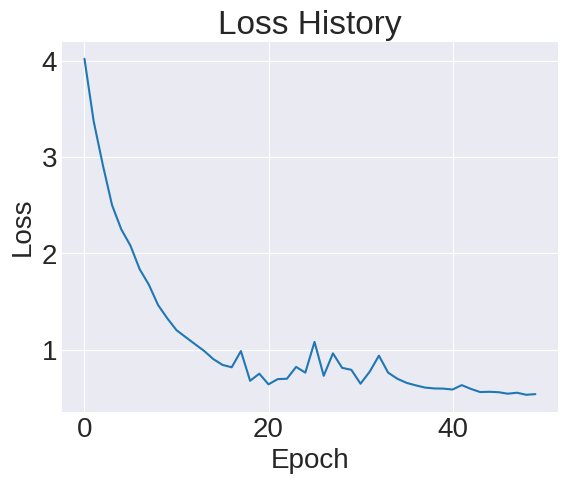

In [32]:
plt.plot(hist)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### 3c. Generate sequences from your RNN (prediction)

This is where you give your trained RNN a prompt and it iteratively generates a sequence of chars that come afterwards.

#### Test: `generate_sequence`

In [33]:
tf.random.set_seed(0)
pig_rnn_gen_test = RNN(len(pigs_dev_vocab), 5, 4)

np.random.seed(0)
gen_output = pig_rnn_gen_test.generate_sequence('pig', 2, char2ind_map_pigs, ind2char_map_pigs)
print(f'For the prompt "pig", your untrained RNN generated "{gen_output}". It should be "pigdn"')
gen_output = pig_rnn_gen_test.generate_sequence('Wolf', 5, char2ind_map_pigs, ind2char_map_pigs)
print(f'For the prompt "Wolf", your untrained RNN generated "{gen_output}". It should be "WolfecOjP"')

For the prompt "pig", your untrained RNN generated "pigcl". It should be "pigdn"
For the prompt "Wolf", your untrained RNN generated "WolfebPhS". It should be "WolfecOjP"


## Task 4: Three Little Pigs

Let's train your RNN on a different version of the Three Little Pigs story (`pigs_50.npz`). Note that this is DIFFERENT than the dev version you have been working with above. In this version, the sequence length is longer (`50` vs `7`). This allows your RNN to learn richer word context and sentence structure.

### 4a. Load in Three Little Pigs 50 corpus

In the cell below, load in the **Three Little Pigs corpus and vocabulary** — the "real" corpus, NOT the "dev" version used above. The sequence length (T) in this case should be `50` and there should be `3` mini-batches.

In [34]:
pigs = np.load(data_path+'/pigs_50.npz')
x_pigs = pigs['x']
y_pigs = pigs['y']

print(f'Three Little Pigs set shape: {x_pigs.shape}')
print(f'Three Little Pigs labels shape: {y_pigs.shape}')

with open(data_path+'/pigs_dev_char2ind_map.pkl', 'rb') as file:
    char2ind_map_pigs = pickle.load(file)
    print('Three Little Pigs char2ind map loaded.')

with open(data_path+'/pigs_dev_ind2char_map.pkl', 'rb') as file:
    ind2char_map_pigs = pickle.load(file)
    print('Three Little Pigs ind2char map loaded.')

Three Little Pigs set shape: (3, 25, 50)
Three Little Pigs labels shape: (3, 25, 50)
Three Little Pigs char2ind map loaded.
Three Little Pigs ind2char map loaded.


### 4b. Different training losses

Train `4` fresh RNNs **on the Little Pigs 50 corpus**, each with a different number of training epochs, either 5, 25, 50, or 100 epochs. For each network:
1. Record the average loss per epoch. After each training run, print out the final loss.
2. Give each trained network the prompt `'by the hair'` `5` different times and have it generate five sequence of 100 characters (*i.e. each net generates the next 100 chars after the prompt multiple times so you can see a range of different outputs*).

You should use default hyperparameters for each network, except:
- embedding size: 20
- number of GRU neurons: 50
- learning rate: 1e-2

**Note:**
- From here on, you should definitely train on the GPU.
- For the most part, your average loss over each epoch should steadily decrease. *However, note that there will be a good amount of variability if you look at the loss over individual mini-batches.*
- Training all 4 networks on the GPU should take 10-15 minutes in total.

In [36]:
# Keep me
tf.random.set_seed(0)
print(x_pigs.shape)
test_rnn = RNN(len(pigs_dev_vocab),20, 50)
hist = test_rnn.fit(x_pigs,y_pigs,5,1e-2,print_every_batch=50, print_every_epoch=1, filename=data_path+'/pigs2_wts.npz')
for i in range(5):
    gen_output = test_rnn.generate_sequence('by the hair', 100, char2ind_map_pigs, ind2char_map_pigs)
    print(gen_output)


(3, 25, 50)
epoch:  0  average loss:  4.065435409545898
epoch:  1  average loss:  3.5726661682128906
epoch:  2  average loss:  3.2074129581451416
epoch:  3  average loss:  3.104961633682251
epoch:  4  average loss:  2.9369945526123047
by the hairrubnees   snrwndl l,tec"nee
heetidck nl  beeay I,h.aS "l ,ao s weuhl R," be niah hr m'l, h s
ianu,ee
by the haire veol.oererinethee
Libg_ aikegieraernl tly t i.rnea nelowp
Pl g A s, tl "iiTtgeelad Etle P danc   n
by the hairedpy ld
naeeokr s,uiOun Mg
 deaWho h,gaiG"eatlls heuLG  tioIf fur,uEutnho,oi b wedeL"p,aI tuusma d "
by the hair o
n  'l, hom,  baeinTa,l noo, icb d s gaiwi eeeia'au thepelesinaniP rueeoetensn le d,n we"
'ds upe 
by the hair,e

e PaP 
 juyD ley re lbhe,e,he ss Leoyus ya vWi or bel, ebo,Wthntliwya a:c keruf,eree de gd"dlato


In [39]:
epochs = [5,25,50,100]
outputs = []
for j in range(4):

    test_rnn = RNN(len(pigs_dev_vocab),20, 50)
    hist = test_rnn.fit(x_pigs,y_pigs,epochs[j],1e-2,print_every_batch=50, print_every_epoch=1, filename = data_path+f'/pigs{j+3}_wts.npz')
    print(f'Epochs = {epochs[j]}')
    for i in range(5):
        outputs.append(test_rnn.generate_sequence('by the hair', 100, char2ind_map_pigs, ind2char_map_pigs))
        print(outputs[-1])

epoch:  0  average loss:  3.765141725540161
epoch:  1  average loss:  3.374835968017578
epoch:  2  average loss:  3.193831205368042
epoch:  3  average loss:  3.132081985473633
epoch:  4  average loss:  3.0140535831451416
Epochs = 5
by the hair Ne bongm,,ite"
i
Yet c al:  hint
hefw
ire,o eei ,alsg wsetftrvt "bua!tdt le nL   totle"yPeWx an he 
by the hair"eafau  bhiezdlirwsnid  Teenu  iostweT nit efE t e ewer Peanangaef sine dbW o ingu t gdea"
erc.  P P
by the hair  t hnd IdeWnmt tcsiymceVcLeiag " w
 i tnufWete ta
,'rebVstyPupiH "tIceno ero "S e hSg wtaL"e ieMplt
by the hairatoWhPs ?"bnee
c At tp h oloet Wld  sesmdTesm
itl e but.Egw Pset fadbdPtmlIennaon tedbgheshdaoP, tt 
by the hairT  t w thd.nVigetfrn p"t a eoI ao I od.lano w". agers"g eS_el tn ugz,e"Eftpleteso"o
SBen fuPlg
el tf
epoch:  0  average loss:  3.958171844482422
epoch:  1  average loss:  3.4393341541290283
epoch:  2  average loss:  3.2453174591064453
epoch:  3  average loss:  3.155797243118286
epoch:  4  average loss:  3.05

In [40]:
for i in range(len(outputs)):
  if i%5 ==0:
    print("\n\nepochs =",epochs[i//5],"\n")
  print(outputs[i])



epochs = 5 

by the hair Ne bongm,,ite"
i
Yet c al:  hint
hefw
ire,o eei ,alsg wsetftrvt "bua!tdt le nL   totle"yPeWx an he 
by the hair"eafau  bhiezdlirwsnid  Teenu  iostweT nit efE t e ewer Peanangaef sine dbW o ingu t gdea"
erc.  P P
by the hair  t hnd IdeWnmt tcsiymceVcLeiag " w
 i tnufWete ta
,'rebVstyPupiH "tIceno ero "S e hSg wtaL"e ieMplt
by the hairatoWhPs ?"bnee
c At tp h oloet Wld  sesmdTesm
itl e but.Egw Pset fadbdPtmlIennaon tedbgheshdaoP, tt 
by the hairT  t w thd.nVigetfrn p"t a eoI ao I od.lano w". agers"g eS_el tn ugz,e"Eftpleteso"o
SBen fuPlg
el tf


epochs = 25 

by the hair at fir the little Piugk wot fece buid to thar time, he

aadte -the Wothean wit to geth r:ow doussen
by the hair in she an, whive;ry as at this said, "Litt he suip to go Noe. So hy chin."

"Oh, wit the Whe soup."
by the hair.
THE LTTHE Souw youh he an" said to the tot mun. san therxokn, And se puff
ahy chinny at juft torn 
by the hair too
heriryyyO, ases at oup, end bemow, and bet a Wolf.

The t

### 4c. Questions

**Question 5:** Print out the 25 generated sequences, organized by the number of epochs the net that generated each sequence was trained for. Make several specific observations about the quality of text generated by each net as a function of the final loss.

**Question 6:** Why is each network not generating the same 100 sequence every time you provide it with the same prompt?

**Answer 5:** The net was more and more coherent as the sequences continued.  This directly corresponds to the final loss. For example, after 100 epochs we see text about the "chinny chin chin" which comes directly from the corpus.  And after 50 epochs the text generated is attempting to write the entire sotry again (likely triggered by the \n character). 5 and 25 epochs make a lot of mistakes and are likely unconfident about which characters could go next, meaning that the random choice is especially problematic.

**Answer 6:** We use the np.random.choice over our letters so we generate characters based on the activation they are assigned rather than the highest activation.

## Task 4: Fairytale story teller

Now that you are debugged your RNN and trained it on the story of the Three Little Pigs, you are ready to train a network on a much larger corpus! Train your RNN on a collection of children's fairytale stories (`fairytales_sm` corpus).

### 4a. Load in the fairytale_sm corpus

Adapt code from above to load in the `fairtale_sm` corpus.
- The vocabulary should have `103` tokens.
- There should be 80 mini-batches, 128 sequences/batch, and sequences have length 125 tokens.

In [41]:
fairytales = np.load(data_path+'/fairytales_sm.npz')
x_ft = fairytales['x']
y_ft = fairytales['y']

print(f'Fairytales set shape: {x_ft.shape}')
print(f'Fairytales labels shape: {y_ft.shape}')

with open(data_path+'/fairytales_sm_char2ind_map.pkl', 'rb') as file:
    char2ind_map_ft = pickle.load(file)
    print('Fairytales char2ind map loaded.')

with open(data_path+'/fairytales_sm_ind2char_map.pkl', 'rb') as file:
    ind2char_map_ft = pickle.load(file)
    print('Fairytales ind2char map loaded.')

Fairytales set shape: (80, 128, 125)
Fairytales labels shape: (80, 128, 125)
Fairytales char2ind map loaded.
Fairytales ind2char map loaded.


### 4b. Train your RNN on the fairytale_sm corpus

**Tips:**
1. Minimize print-outs to ensure your network training does not get bogged down, but it is helpful to have a progress printout with every loss after every epoch.
2. This training session will take several hours on the GPU. Before running your "real" training session, I would suggest doing a short 1 epoch run and then generate text to make sure there are no unexpected crashes.
3. How long you train for is up to you. Lower final losses will result in better/more coherent generated text. A rough target is avg loss of `0.7` (or better).
4. Likewise, hyperparameters are also up to you. A recommended default is an embedding size of `32`, `1000` GRU neurons, and the default learning rate `1e-3` (*this is a lot bigger of a corpus than The Three Little Pigs!*).
5. The questions in the next section revolve around text generated from your RNN. You may want to print out the RNN generated text in the cell below immediately after training the net because then you can look at the output even if Colab kills your runtime due to inactivity.
6. Please let me know if you run into Colab's limits (e.g. you are unable to use the GPU runtime after some usage, Colab throttles your training to a crawl, etc.). I will try to set your team up with another solution.
7. You are being provided with methods (`save_wts`, `load_wts` in `RNN`) to save your network weights to a file. Make sure your training code saves the weights after every epoch of training. If you do this and your training gets interrupts after several hours, create a new RNN with the same hyperparameters as before, but in the RNN constructor set `load_wts=True`. This will restore your network's weights to what they were right before your training got cut off!

In [42]:
# Keep me
tf.random.set_seed(0)

# Your code here
ft_rnn = RNN(len(char2ind_map_ft.keys()),32, 1000)
ft_rnn.load_wts(data_path+'/ft2_wts.npz')
hist = ft_rnn.fit(x_ft,y_ft,10,1e-3,print_every_batch=100, print_every_epoch=1, filename = data_path+"/ft3_wts.npz")


epoch:  0  average loss:  0.6878598928451538
epoch:  1  average loss:  0.6977488994598389
epoch:  2  average loss:  0.6838098764419556
epoch:  3  average loss:  0.671908974647522


KeyboardInterrupt: 

In [43]:
seq_1 = ft_rnn.generate_sequence('Once upon a time', 1200,char2ind_map_ft,ind2char_map_ft)
seq2 = ft_rnn.generate_sequence('A knight once sat at a large round table', 1200,char2ind_map_ft,ind2char_map_ft)
seq3 =ft_rnn.generate_sequence('In a hole in the ground there lived a hobbit. Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell, nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat: it was a hobbit-hole, and that means comfort.', 5000,char2ind_map_ft,ind2char_map_ft)
seq4 = ft_rnn.generate_sequence('Once upon a time', 100,char2ind_map_ft,ind2char_map_ft)

In [44]:
print(seq_1)
print(seq2)
print(seq3)
print(seq4)

Once upon a time arriving near
to see her royaltiin, in scrrench with the beginning of
animantal tobles that thus spring. It gops and summer's
daughter, thought instagunny to go, it was let in twarmable and
searching one magning the shades. Thus came out witt gift and dismay
in the hote that the sea was consented. The work aroined on to a
canny from the popital toker than he had fire on the
sunshine, and ran on his hope he covered in three sudsing more
belies that the Sea King Ransulan
Whitt nothing. For a moment that nothing to be so; he had never even
growing in letting his redarts for all the time, comprisend of his return.

Book of forth wicked wish, and spilling it with before the Hen
Poly Turesle to be glad so suce that it began
that at the warRs racked hir on the house-to Leapnish.

Before the wind must do so as the pours of swimming low in the
most seczintong yellow waves around, burning this time to Unablesta tales.




THE STORY OF THE ORAN  An Old Worthy Coppos. But he calle

### 4c. Generate fairytales using your trained RNN

**Have fun** and try out several prompts! Among the ones you try, include `'Once upon a time'`.

### 4d. Questions
**Question 7:** Do any groups of words/patterns recur across the generated text? What does this tell you about the themes/content in the corpus?

**Question 8:** How is the grammar in the generated text? Why might this be the case?

**Question 9:** How is the coherence of the generated story in the text? Why might this be the case?

**Question 10:** What are some of your favorite generated passages / those that delighted you / those that made you laugh?

**Answer 7:** The text likes to use all caps and 'name' a story after the \n character.  Furthermore, it likes to make quotes everwhere occassionally forgetting to close them.

**Answer 8:** The grammer is pretty good! It makes sentences, uses commas, makes paragraphs, captializes words.

**Answer 9:**
As the text progresses it becomes less and less coherent.  I expect this is because the context from the prompt is 'forgotten' as we get to a certain point in the text and it is only wokring with the likely error filled output that it has already made.  

**Answer 10:**
My favorite generated passage is from when I put in the first sentences of the Hobbit.  I got a cool bit of text after that with my favorite passage being: "Now a moment was is to see how strong they grew to resent his forejoving gare
collected in the need. The form lay quiet, the
rain pupted him. While the wizard could not get the
ogen leg like to save him for so long. No one hunged and down and they
walched all the truckest prefious tame, that to his money with his
captover and uglong to valce to him."  This is pretty incoherent but I liked that it came up with a wizard and a forboding body, which are part of the hobbit but not necessarily in the prompt that I gave. This mostly demonstrates that the themes of the corpus intersecting significantly to the Hobbit though.

## Extensions

### a. Reminder: AI Policy

The goal of extensions is to learn and create something new beyond the base project that excites you. To serve this goal and out of fairness to your hardworking classmates, **AI (e.g. ChatGPT, Copilot, etc.) should NOT be used in ANY way on this project and extensions.** This includes both written analysis, plotting, and code. We will only grade **your** work, not an AI's. **We will stop grading your project if we notice AI-generated content (to any capacity).**

### b. Guidelines

To receive credit for any extension, you must:
1. Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
2. **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
3. Include (*labeled!*) plots and/or numbers to present your results.
4. Write up your extensions below or in a separate notebook.
5. Give kudos to all sources, including anyone that you consulted.

### c. Suggestions

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

The ideas below are **suggested** extensions — feel free to go in another direction related to this project that is not listed!

### 1. Weight initialization schemes

We used He/Kaiming initialization because it supposedly speeds up training: getting the network to decrease loss faster than other methods. Compare the training loss curves for different weight initialization schemes. Is He/Kaiming the best?

### 2. Hyperparameter search

Focus on certain network hyperparameters (e.g. embedding size, number of GRU neurons) and either qualitatively or quantitatively analyze the impact on RNN performance (e.g. quality of generated text).

### 3. Preprocessing pipeline + your own corpus

- Implement your own pipeline for creating the corpus vocabulary, token-to-int-code dictionaries, etc. Then train a RNN on a corpus of your choice.
- Analyze the influence of sequence length and the quality of the RNN generated text.

### 4. Stacked GRU layers

We used a single GRU layer, but you can stack multiple GRU layers together to learn more complex/longer sequences. Adapt your network to support this and assess how it impacts generated text.

### 5. Temperature in predictions

In `generate_sequence` we predicted the next token in proportion of its softmax probability. You can introduce a "temperature" parameter that adjusts the softmax probability distribution to force the network to "take more chances" or "be more conservative" with the next char that it takes. For example, the temperature could raise the probability distribution by some power. Explore how the temperature affects the text that the network generates.

### 6. Train on larger fairytale corpus

There is also an even larger fairytale corpus `fairytale_lg` available to you. Train a RNN on the larger corpus and compare the generated text, final loss, speed of learning to the RNN you trained on `fairytale_sm`.

### 7. Analyze/visualize probabilities of next char token

- Modify `generate_sequence` to plot the softmax probability distribution for picking the next char. It is helpful to be thoughtful in how you label the plot (e.g. line the possible next chars on the x-axis, indicate in the title what the previous char was, indicate what char is actually selected as the next char from the distribution). Use the plots to help make sense of which chars are predicted from prompts of your choice.
- Explore how the generated text changes if you swap out the probability-based method of selecting the next char with one that always selects the char with the highest probability.